# Stock prediction using LSTM 
## FTSE Bursa Malaysia KLCI Index (FBM KLCI)
##### *open in tf env

In [1]:
import keras
import keras.backend as K
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.utils.vis_utils import plot_model

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

import pandas as pd
import datetime
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mandates


print("All library loaded.")

All library loaded.


In [2]:
# get historical data from Yahoo Finance for FTSE Bursa Malaysia KLCI (fbmkl)
fbmkl = yf.Ticker("^KLSE")
fbmkl = fbmkl.history(period="max")
# fbmkl.reset_index(inplace=True)
fbmkl

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-12-03 00:00:00+08:00,1018.729980,1027.410034,1018.729980,1023.919983,0,0.0,0.0
1993-12-06 00:00:00+08:00,1027.680054,1041.109985,1027.680054,1041.109985,0,0.0,0.0
1993-12-07 00:00:00+08:00,1046.089966,1063.250000,1046.089966,1063.250000,0,0.0,0.0
1993-12-08 00:00:00+08:00,1064.800049,1071.020020,1060.250000,1060.790039,0,0.0,0.0
1993-12-09 00:00:00+08:00,1059.939941,1067.339966,1058.180054,1067.339966,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-01 00:00:00+08:00,1458.900024,1462.560059,1449.020020,1451.239990,98171000,0.0,0.0
2023-08-02 00:00:00+08:00,1449.449951,1450.280029,1441.849976,1444.560059,91589600,0.0,0.0
2023-08-03 00:00:00+08:00,1441.369995,1442.780029,1433.040039,1441.849976,89240200,0.0,0.0


### Cleaning & visualizing data
#### Date format, remove unwanted column

In [3]:
fbmkl.reset_index(inplace=True) # reset index to allow Date format
fbmkl["Date"] = fbmkl["Date"].dt.strftime("%Y-%m-%d") # reformat date
fbmkl.set_index("Date", inplace=True) # set Date as index again
fbmkl = fbmkl.drop(["Dividends", "Stock Splits"],axis=1) # specify drop column
fbmkl

,Open,High,Low,Close,Volume
Date,,,,,
1993-12-03,1018.729980,1027.410034,1018.729980,1023.919983,0
1993-12-06,1027.680054,1041.109985,1027.680054,1041.109985,0
1993-12-07,1046.089966,1063.250000,1046.089966,1063.250000,0
1993-12-08,1064.800049,1071.020020,1060.250000,1060.790039,0
1993-12-09,1059.939941,1067.339966,1058.180054,1067.339966,0
...,...,...,...,...,...
2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000
2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600
2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200


In [4]:
# using matplotlib to plot date as index (date index is of object type) takes longer time
# make a copy of data where index is reset
fbmkl_rst = fbmkl.copy()
fbmkl_rst.reset_index(inplace=True)
fbmkl_rst.tail()

,Date,Open,High,Low,Close,Volume
7286,2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000
7287,2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600
7288,2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200
7289,2023-08-04,1442.489990,1447.130005,1442.229980,1445.209961,70523900
7290,2023-08-07,1444.890015,1449.380005,1442.130005,1445.810059,0


In [5]:
fbmkl_rst_d = fbmkl_rst.copy() # make copy

In [6]:
fbmkl_rst_d.shape

(7291, 6)

In [7]:
fbmkl_rst_d.info

<bound method DataFrame.info of             Date         Open         High          Low        Close    Volume
0     1993-12-03  1018.729980  1027.410034  1018.729980  1023.919983         0
1     1993-12-06  1027.680054  1041.109985  1027.680054  1041.109985         0
2     1993-12-07  1046.089966  1063.250000  1046.089966  1063.250000         0
3     1993-12-08  1064.800049  1071.020020  1060.250000  1060.790039         0
4     1993-12-09  1059.939941  1067.339966  1058.180054  1067.339966         0
...          ...          ...          ...          ...          ...       ...
7286  2023-08-01  1458.900024  1462.560059  1449.020020  1451.239990  98171000
7287  2023-08-02  1449.449951  1450.280029  1441.849976  1444.560059  91589600
7288  2023-08-03  1441.369995  1442.780029  1433.040039  1441.849976  89240200
7289  2023-08-04  1442.489990  1447.130005  1442.229980  1445.209961  70523900
7290  2023-08-07  1444.890015  1449.380005  1442.130005  1445.810059         0

[7291 rows x 6 colu

### Long Short-Term Model (LSTM) model
##### Long short-term memory (LSTM) is a specialized architecture that can "memorize" patterns from historical sequences of data and extrapolate such patterns to future events. 
##### A type of Recurrent Neural Network (RNN).

In [8]:
# split data into a train & test set by 80:20
train_data = fbmkl_rst_d.iloc[:-1500] # take all except the last 1500
test_data = fbmkl_rst_d.iloc[-1500:]  # take the last 1500 

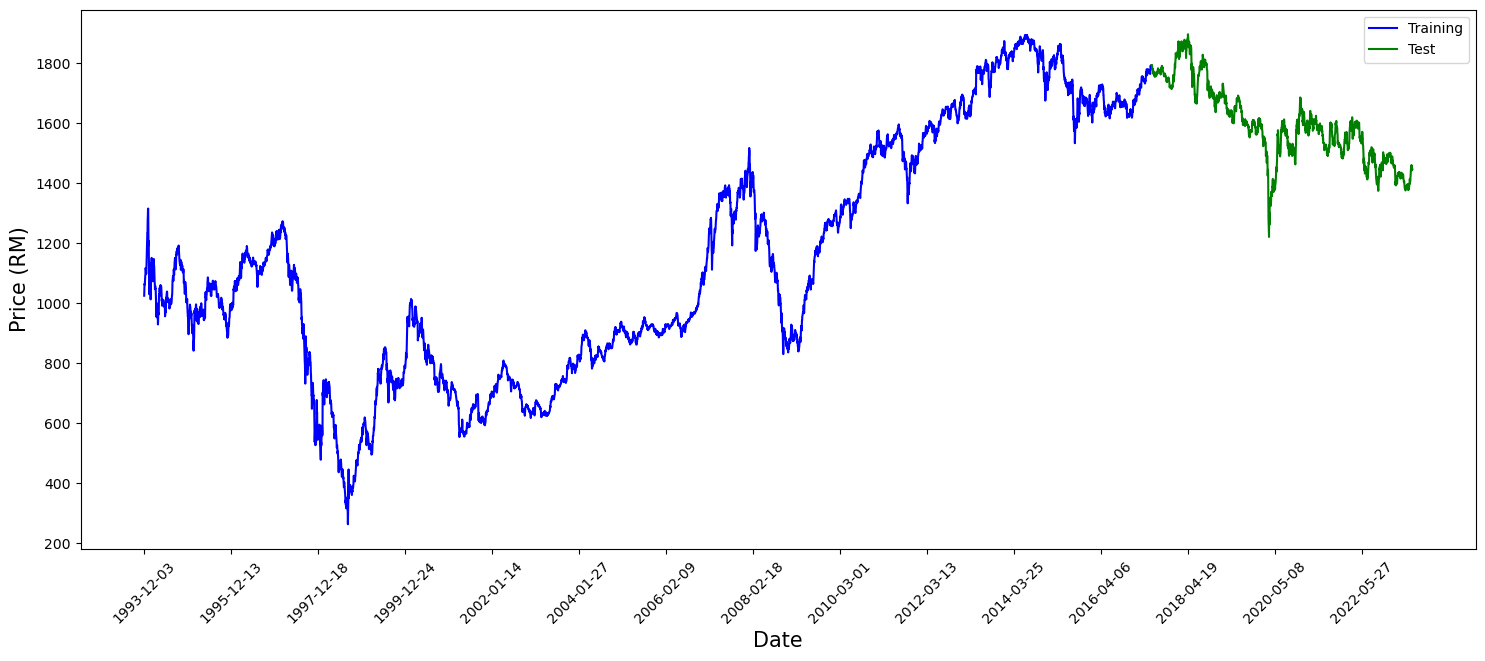

In [9]:
# show plot of train & test data
plt.figure(figsize=(18,7))
plt.plot(train_data["Close"], "blue", label="Training")
plt.plot(test_data["Close"], "green", label="Test")
plt.xlabel("Date", fontsize=15)
plt.ylabel("Price (RM)", fontsize=15)
plt.xticks(np.arange(0, 7290, 500), fbmkl_rst_d["Date"][0:7290:500], rotation=45)
plt.legend()

Add features

In [10]:
fbmkl_rst_copy = fbmkl_rst.set_index('Date')
fbmkl_rst_copy

,Open,High,Low,Close,Volume
Date,,,,,
1993-12-03,1018.729980,1027.410034,1018.729980,1023.919983,0
1993-12-06,1027.680054,1041.109985,1027.680054,1041.109985,0
1993-12-07,1046.089966,1063.250000,1046.089966,1063.250000,0
1993-12-08,1064.800049,1071.020020,1060.250000,1060.790039,0
1993-12-09,1059.939941,1067.339966,1058.180054,1067.339966,0
...,...,...,...,...,...
2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000
2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600
2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200


In [11]:
fbmkl_rst_d = fbmkl_rst_copy.copy()
fbmkl_rst_d

,Open,High,Low,Close,Volume
Date,,,,,
1993-12-03,1018.729980,1027.410034,1018.729980,1023.919983,0
1993-12-06,1027.680054,1041.109985,1027.680054,1041.109985,0
1993-12-07,1046.089966,1063.250000,1046.089966,1063.250000,0
1993-12-08,1064.800049,1071.020020,1060.250000,1060.790039,0
1993-12-09,1059.939941,1067.339966,1058.180054,1067.339966,0
...,...,...,...,...,...
2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000
2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600
2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200


In [12]:
# mov = days of 2 ~ mean close price of the last 2 days
# last 2 days, 5=last week, 20=last months, 60=last 3 months, 250=last year

movs = [5, 20, 60, 120]
new_features = []

for mov in movs:
    moving_averages = fbmkl_rst_d.rolling(mov).mean() # calculate moving averages
    ma_column = f"MA_{mov}" # create new column name based on {mov} day 
    fbmkl_rst_d[ma_column] = moving_averages["Close"] # create new column in df, ratio of close/moving averages 

    new_features += [ma_column] # append to new predictors list

In [13]:
fbmkl_rst_d.tail()

,Open,High,Low,Close,Volume,MA_5,MA_20,MA_60,MA_120
Date,,,,,,,,,
2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000,1452.316016,1413.965503,1404.984174,1421.730419
2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600,1451.370020,1416.569006,1405.209507,1421.347836
2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200,1449.486011,1419.166504,1405.344674,1421.060086
2023-08-04,1442.489990,1447.130005,1442.229980,1445.209961,70523900,1448.458008,1422.129504,1405.554340,1420.847252
2023-08-07,1444.890015,1449.380005,1442.130005,1445.810059,0,1445.734009,1425.536505,1405.889840,1420.690336


In [14]:
data_copy = fbmkl_rst_d.copy()

In [15]:
data_copy = data_copy.dropna(axis=0)

In [16]:
data_copy.shape, data_copy.isnull().values.any()

((7172, 9), False)

In [17]:
data_copy.tail()

,Open,High,Low,Close,Volume,MA_5,MA_20,MA_60,MA_120
Date,,,,,,,,,
2023-08-01,1458.900024,1462.560059,1449.020020,1451.239990,98171000,1452.316016,1413.965503,1404.984174,1421.730419
2023-08-02,1449.449951,1450.280029,1441.849976,1444.560059,91589600,1451.370020,1416.569006,1405.209507,1421.347836
2023-08-03,1441.369995,1442.780029,1433.040039,1441.849976,89240200,1449.486011,1419.166504,1405.344674,1421.060086
2023-08-04,1442.489990,1447.130005,1442.229980,1445.209961,70523900,1448.458008,1422.129504,1405.554340,1420.847252
2023-08-07,1444.890015,1449.380005,1442.130005,1445.810059,0,1445.734009,1425.536505,1405.889840,1420.690336


In [18]:
# set target variable
target_var = data_copy["Close"] 

# select features
features = ["Open", "High", "Low", "Volume", "MA_5", "MA_20", "MA_60", "MA_120",]

In [19]:
# scaling
scaler = MinMaxScaler()
feature_tx = scaler.fit_transform(data_copy[features])
feature_tx = pd.DataFrame(columns=features, data=feature_tx, index=data_copy.index)
feature_tx.head()

,Open,High,Low,Volume,MA_5,MA_20,MA_60,MA_120
Date,,,,,,,,
1994-06-01,0.444110,0.435276,0.438519,0.0,0.437178,0.432192,0.424463,0.449718
1994-06-02,0.437665,0.428424,0.424313,0.0,0.431955,0.429860,0.423194,0.449327
1994-06-03,0.423146,0.418662,0.421399,0.0,0.427609,0.428530,0.422104,0.448895
1994-06-06,0.428809,0.424258,0.429944,0.0,0.424340,0.427200,0.421270,0.448363
1994-06-07,0.430507,0.427400,0.434360,0.0,0.421665,0.426617,0.420345,0.447859


In [20]:
feature_tx.tail()

,Open,High,Low,Volume,MA_5,MA_20,MA_60,MA_120
Date,,,,,,,,
2023-08-01,0.731479,0.729131,0.728497,0.120181,0.724835,0.697167,0.687408,0.693833
2023-08-02,0.725668,0.721461,0.724099,0.112124,0.724241,0.698835,0.687557,0.693571
2023-08-03,0.720699,0.716776,0.718695,0.109248,0.723058,0.700499,0.687647,0.693373
2023-08-04,0.721388,0.719493,0.724332,0.086335,0.722413,0.702397,0.687785,0.693228
2023-08-07,0.722863,0.720898,0.724271,0.000000,0.720704,0.704580,0.688007,0.693120


In [21]:
# create training & test set
tscv = TimeSeriesSplit(n_splits=20) # test data 20%, train 80%
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None)


In [22]:
for train_index, test_index in tscv.split(feature_tx):
    X_train, X_test = feature_tx[:len(train_index)], feature_tx[len(train_index):]
    y_train, y_test = target_var[:len(train_index)].values.ravel(), target_var[len(train_index):].values.ravel()
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6831, 8) (341, 8)
(6831,) (341,)


In [23]:
# data processing for LSTM; to match the format (nos. of samples, 1, nos. of features)
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
print(trainX.shape, trainX.shape)
print(X_train.shape, X_test.shape)

(6831, 8) (6831, 8)
(6831, 1, 8) (341, 1, 8)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


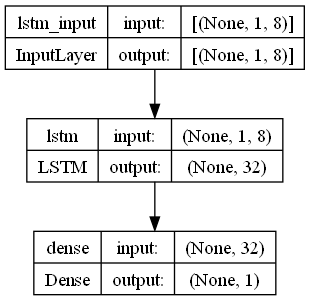

In [24]:
# build model
layers = [LSTM(units=32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False),
        Dense(units=1)]

lstm_model = Sequential(layers=layers)
lstm_model.summary()
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

In [25]:
# compile model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [26]:
#train model
history=lstm_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=.20, shuffle=False)

Epoch 1/100
547/547 [==============================] - 4s 4ms/step - loss: 1339321.5000 - val_loss: 2403845.5000
Epoch 2/100
547/547 [==============================] - 2s 3ms/step - loss: 1145182.3750 - val_loss: 1954405.0000
Epoch 3/100
547/547 [==============================] - 2s 3ms/step - loss: 894881.3750 - val_loss: 1448382.1250
Epoch 4/100
547/547 [==============================] - 2s 3ms/step - loss: 633527.2500 - val_loss: 957889.6250
Epoch 5/100
547/547 [==============================] - 2s 3ms/step - loss: 387142.5625 - val_loss: 514071.8750
Epoch 6/100
547/547 [==============================] - 2s 3ms/step - loss: 195252.4688 - val_loss: 223653.2656
Epoch 7/100
547/547 [==============================] - 2s 3ms/step - loss: 78761.6484 - val_loss: 70288.2188
Epoch 8/100
547/547 [==============================] - 2s 3ms/step - loss: 23676.8145 - val_loss: 13568.7920
Epoch 9/100
547/547 [==============================] - 2s 3ms/step - loss: 5608.0664 - val_loss: 1586.3329
Epoc

Epoch 78/100
547/547 [==============================] - 2s 3ms/step - loss: 145.6770 - val_loss: 129.6763
Epoch 79/100
547/547 [==============================] - 2s 3ms/step - loss: 126.6937 - val_loss: 117.7720
Epoch 80/100
547/547 [==============================] - 2s 3ms/step - loss: 112.1255 - val_loss: 109.8452
Epoch 81/100
547/547 [==============================] - 2s 3ms/step - loss: 101.7235 - val_loss: 104.8430
Epoch 82/100
547/547 [==============================] - 2s 3ms/step - loss: 94.5760 - val_loss: 101.4654
Epoch 83/100
547/547 [==============================] - 2s 3ms/step - loss: 89.6603 - val_loss: 98.7709
Epoch 84/100
547/547 [==============================] - 2s 3ms/step - loss: 86.1830 - val_loss: 96.3823
Epoch 85/100
547/547 [==============================] - 2s 3ms/step - loss: 83.6383 - val_loss: 94.2365
Epoch 86/100
547/547 [==============================] - 2s 3ms/step - loss: 81.7261 - val_loss: 92.3596
Epoch 87/100
547/547 [==============================] -

In [27]:
#LSTM Prediction
y_pred= lstm_model.predict(X_test)

11/11 [==============================] - 0s 3ms/step


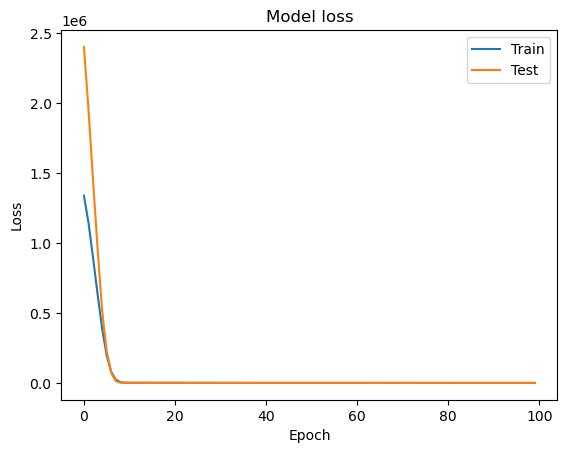

In [28]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

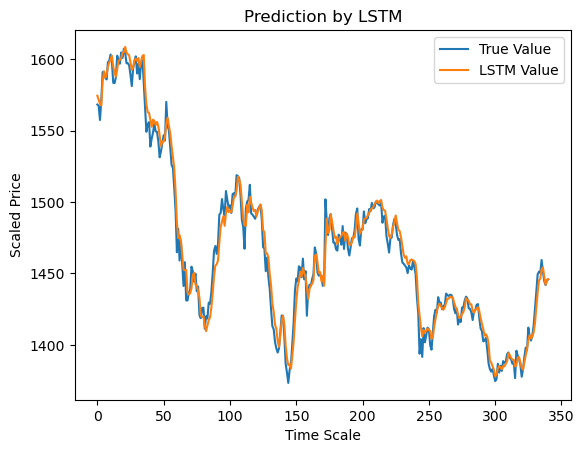

In [29]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()